In [2]:
from pyclustering.cluster.bsas import bsas
import numpy as np
import matplotlib.pyplot as plt
import cv2
fig_size =[12,9]
plt.rcParams["figure.figsize"] = fig_size

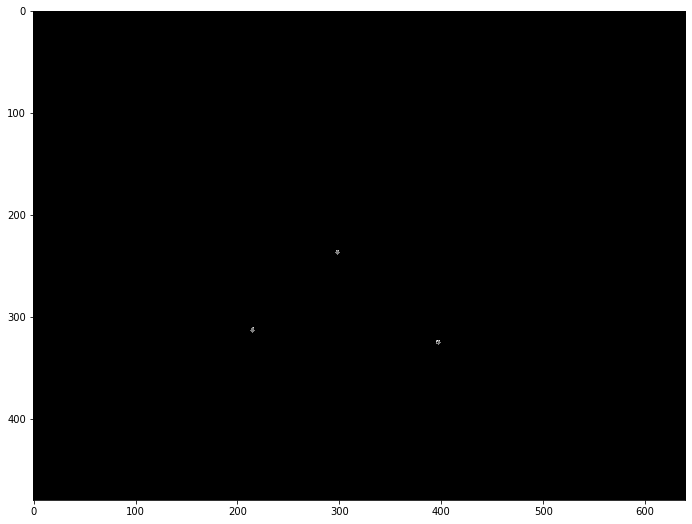

In [115]:
img = cv2.imread('faulty_image.jpg')
img_gray=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret,img_thresh = cv2.threshold(img_gray,100,255,cv2.THRESH_TOZERO)
nonzro_samples = cv2.findNonZero(img_thresh).reshape(-1, 2).astype('float32')
plt.imshow(img_thresh,cmap='gray')
plt.show()

In [117]:
max_clusters = 8
threshold = 20
bsas_instance = bsas(nonzro_samples, max_clusters, threshold)
bsas_instance.process()
clusters = bsas_instance.get_clusters()
#representatives = bsas_instance.get_representatives()

In [118]:
cms=[]
ROIs=np.zeros((len(clusters),4))
for i,cluster in enumerate(clusters):
    current_batch=nonzro_samples[cluster]
    cms.append(np.sum(current_batch,axis=0)/current_batch.shape[0])
    row_max=np.max(current_batch[:,1],axis=0)+6
    row_min=np.min(current_batch[:,1],axis=0)-6
    col_max=np.max(current_batch[:,0],axis=0)+6
    col_min=np.min(current_batch[:,0],axis=0)-6
    ROIs[i,:]=[row_min,row_max,col_min,col_max]

[229 245 290 306]
[305 321 207 223]
[317 333 389 405]


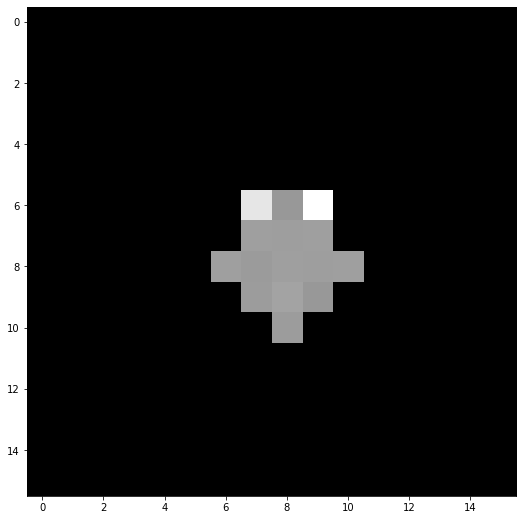

In [119]:
image_ROIs=[]
for roi in ROIs.astype('int32'):
    print(roi)
    image_ROIs.append(img_thresh.copy()[roi[0]:roi[1],roi[2]:roi[3]])
plt.imshow(image_ROIs[0],cmap='gray')
plt.show()

In [125]:
index=0 #Which ROI do you want to consider?
frame=image_ROIs[index]
roi_range=ROIs[index].astype('float32')
params = cv2.SimpleBlobDetector_Params()
params.minThreshold = 50;
params.maxThreshold = 255;
params.filterByArea = True
params.minArea = 0
params.filterByCircularity = True
params.minCircularity = 0.1
params.filterByConvexity = True
params.minConvexity = 0.1
params.filterByInertia = True
params.minInertiaRatio = 0.1
params.blobColor = 255
 
ver = (cv2.__version__).split('.')
if int(ver[0]) < 3 :
    detector = cv2.SimpleBlobDetector(params)
else : 
    detector = cv2.SimpleBlobDetector_create(params)

keypoints = detector.detect(frame)
print(keypoints[0].pt)
print(roi_range)

(8.0, 7.814815044403076)
[229. 245. 290. 306.]


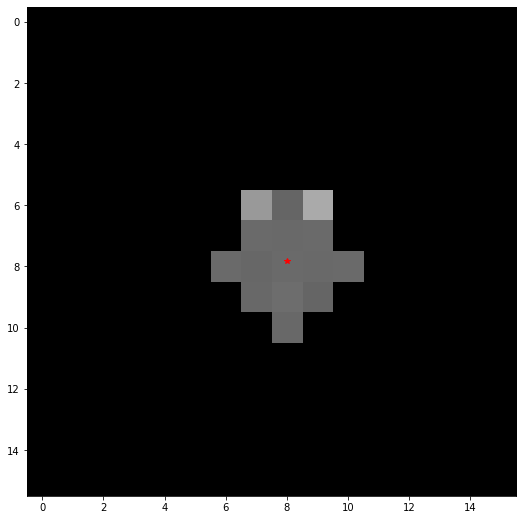

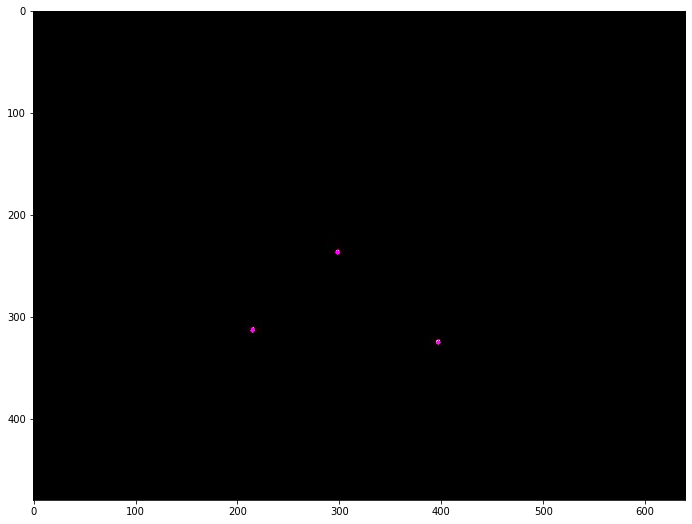

In [126]:
frame_clr=cv2.cvtColor(frame,cv2.COLOR_GRAY2RGB)
im_with_keypoints = cv2.drawKeypoints(frame_clr, keypoints, np.array([]), (255,0,0), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(frame_clr)
for key in keypoints:
    plt.plot(key.pt[0],key.pt[1],'r*')
plt.show()
img = cv2.imread('faulty_image.jpg')
# roi_range[2] corresponds to roi_x_min and keypoints[0].pt[0] corresponds to the x component of the keypoint
for key in keypoints:
    cv2.circle(img,(int(round(key.pt[0]+roi_range[2])), int(round(key.pt[1]+roi_range[0]))), 2, (255,0,255), -1)
plt.imshow(img)
plt.show()

In [ ]:
len(keypoints)

In [84]:
import cv2
import numpy as np
from pyclustering.cluster.bsas import bsas
class markerExteractor(object):
    def __init__(self):
        self.max_clusters = 8
        self.threshold = 20
        self.blubParams = cv2.SimpleBlobDetector_Params()
        self.blubParams.minThreshold = 50;
        self.blubParams.maxThreshold = 255;
        self.blubParams.filterByArea = True
        self.blubParams.minArea = 0
        self.blubParams.filterByCircularity = True
        self.blubParams.minCircularity = 0.3
        self.blubParams.filterByConvexity = True
        self.blubParams.minConvexity = 0.7
        self.blubParams.filterByInertia = True
        self.blubParams.minInertiaRatio = 0.1
        self.blubParams.blobColor = 255
        ver = (cv2.__version__).split('.')
        if int(ver[0]) < 3 :
            self.blubDetector = cv2.SimpleBlobDetector(self.blubParams)
        else : 
            self.blubDetector = cv2.SimpleBlobDetector_create(self.blubParams)
    def detect(self,frame):
        self.cms=[]
        self.image_ROIs=[]
        self.keypoints=[]
        img_gray=cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        ret,img_thresh = cv2.threshold(img_gray,100,255,cv2.THRESH_TOZERO)
        #Find the clusters
        self.nonzro_samples = cv2.findNonZero(img_thresh)
        if self.nonzro_samples is None:
            return None
        else:
            self.nonzro_samples=self.nonzro_samples.reshape(-1, 2).astype('float32')
        bsas_instance = bsas(self.nonzro_samples, self.max_clusters, self.threshold)
        bsas_instance.process()
        clusters = bsas_instance.get_clusters()
        #Calculate the center of the clusters and the Regions of Interests
        self.ROIs=np.zeros((len(clusters),4))
        for i,cluster in enumerate(clusters):
            current_batch=self.nonzro_samples[cluster]
            self.cms.append(np.sum(current_batch,axis=0)/current_batch.shape[0])
            row_max=np.max(current_batch[:,1],axis=0)+6
            row_min=np.min(current_batch[:,1],axis=0)-6
            col_max=np.max(current_batch[:,0],axis=0)+6
            col_min=np.min(current_batch[:,0],axis=0)-6
            self.ROIs[i,:]=[row_min,row_max,col_min,col_max]
        for roi in self.ROIs.astype('int32'):
            self.image_ROIs.append(img_thresh.copy()[roi[0]:roi[1],roi[2]:roi[3]])
        #Return The Results
        marker_points=[]
        for i,roi in enumerate(self.image_ROIs):
            keys_in_roi=self.blubDetector.detect(roi)
            for key in keys_in_roi:
                #Calculate the global coordinate of marker points. The points are returned in (X(Col),Y(Row)) coordinate. 
                marker_points.append([key.pt[0]+self.ROIs.astype('float32')[i,2],key.pt[1]+self.ROIs.astype('float32')[i,0]])
        return np.array(marker_points)

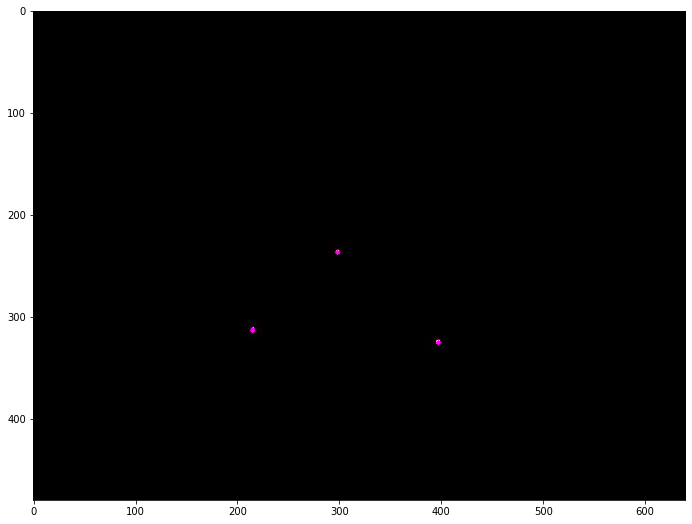

True

In [128]:
img = cv2.imread('faulty_image.jpg')
markerExteractor_inst=markerExteractor()
points=markerExteractor_inst.detect(img)
for i in range(len(points)):
    cv2.circle(img,(int(round(points[i,0])), int(round(points[i,1]))), 2, (255,0,255), -1)
plt.imshow(img)
plt.show()
cv2.imwrite('res.png',img)

In [129]:
#Testing the algorithm with a stream of images
markerExteractor_inst=markerExteractor()
cap=cv2.VideoCapture('/home/rouholla/Stereo_6DOF_Tracker/Marker_Extraction/output_rigt.avi')
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('output_debug.avi', fourcc, 30.0, (int(cap.get(3)),int(cap.get(4))))
while cap.isOpened():
    ret,img=cap.read()
    raw_img=img.copy()
    if ret==True:
        points=markerExteractor_inst.detect(img)
        if points is not None:
            for i in range(len(points)):
                cv2.circle(img,(int(round(points[i,0])), int(round(points[i,1]))), 2, (255,0,255), -1)
        cv2.imshow('Frame',img)
        out.write(img)
        if cv2.waitKey(20) & 0xFF == ord('q'):
            cv2.imwrite('faulty_image.jpg',raw_img)
            break
    else:
        break #Break the while loop if no frames could be captured
cv2.destroyAllWindows()     
out.release()
cap.release()

In [86]:
import yaml
class undistrodMarkers:
    def __init__(self,config_file_name):
        with open(config_file_name, 'r') as f:
            calib = yaml.safe_load(f.read())
        self.K = np.array(calib['camera_matrix']['data']).reshape(calib['camera_matrix']['rows'],calib['camera_matrix']['cols'])
        self.D = np.array(calib['distortion_coefficients']['data']).reshape(-1, 5)
        self.P = np.array(calib['projection_matrix']['data']).reshape(3, 4)
        self.R = np.array(calib['rectification_matrix']['data']).reshape(3, 3)
        self.img_width = calib['image_width']
        self.img_height = calib['image_height']
    def process(self,points):
        lpts_ud=cv2.undistortPoints(points.reshape(-1,1,2).astype(np.float32), self.K, self.D,P=self.P,R=self.R)
        return cv2.convertPointsToHomogeneous(np.float32(lpts_ud))

leftUndist = undistrodMarkers('left.yml')
rightUndist = undistrodMarkers('right.yml')
        

## Phase 2
Now we use the tracker we just created to build our 6DOF tracker system

In [261]:
#Testing the algorithm with a stream of images
markerExteractor_inst=markerExteractor()
cap_right=cv2.VideoCapture('/home/rouholla/Stereo_6DOF_Tracker/Marker_Extraction/output_right_new.avi')
cap_left=cv2.VideoCapture('/home/rouholla/Stereo_6DOF_Tracker/Marker_Extraction/output_left_new.avi')
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('output_debug.avi', fourcc, 30.0, (int(cap_left.get(3)),int(cap_left.get(4))))

while cap_left.isOpened():
    ret,img_left=cap_left.read()
    ret,img_right=cap_right.read()
    if ret==True:
        points_left=markerExteractor_inst.detect(img_left)
        points_right=markerExteractor_inst.detect(img_right)
        if (points_left is not None) and (points_right is not None):
            left_ud=leftUndist.process(points_left)
            right_ud=rightUndist.process(points_right)
            for i in range(min(len(points_left),len(points_right))):
                cv2.circle(img_left,(int(round(points_left[i,0])), int(round(points_left[i,1]))), 2, (255,0,255), -1)
                cv2.circle(img_right,(int(round(points_right[i,0])), int(round(points_right[i,1]))), 2, (255,0,255), -1)

                
        cv2.imshow('Frame',np.hstack([img_left,img_right]))
        out.write(img_left)
        if cv2.waitKey(2) & 0xFF == ord('q'):
            cv2.imwrite('faulty_image.jpg',img_right)
            break
    else:
        break #Break the while loop if no frames could be captured
cv2.destroyAllWindows()     
out.release()
cap_left.release()
cap_right.release()

In [97]:
cv2.destroyAllWindows()     


In [262]:
#lpts=np.array([329.875, 378.875]).reshape(1,2)
#rpts=np.array([336.5, 334.5]).reshape(1,2)
#left_ud=leftUndist.process(lpts)
#right_ud=rightUndist.process(rpts)
print(left_ud.reshape(-1,3))
print ('right')
print(right_ud.reshape(-1,3))

[[315.41983 224.27902   1.     ]
 [446.92328 259.1822    1.     ]
 [275.28143 333.77292   1.     ]]
right
[[178.09947 220.67093   1.     ]
 [296.1252  254.92276   1.     ]
 [142.3107  329.09772   1.     ]]


In [229]:
left_ud-right_ud
left_ud.reshape(-1,3)[:,0:2]

array([[316.9997 , 224.40216],
       [432.04218, 257.04175],
       [266.68915, 326.40543]], dtype=float32)

In [254]:
#Create the corresponding matrix
def process_filtered_connection_matrix(connection_matrix):
    m,n=connection_matrix.shape
    matchesA=[]
    matchesB=[]
    for i in range(m):
        if connection_matrix[i,:].any()==1:
            matche=np.where((connection_matrix==connection_matrix[i,:]).all(axis=1))[0] #What rows are identical
            if matche.tolist() not in matchesA:# if it's a new kind of row save the place where they exist
                matchesA.append(matche.tolist())
                matchesB.append(np.where(connection_matrix[i,:]==1)[0].tolist())
    return matchesA,matchesB  
def get_secondary_correspondings(matchesA,matchesB,points_left,points_right):
    points_in_matchesA=[]
    points_in_matchesB=[]
    for clusters in matchesA:
        points_in_cluster=points_left[clusters,:]
        points_in_matchesA.append(points_in_cluster[points_in_cluster[:,0].argsort(),:].tolist())
    for clusters in matchesB:
        points_in_cluster=points_right[clusters,:]
        points_in_matchesB.append(points_in_cluster[points_in_cluster[:,0].argsort(),:].tolist())   
    return np.array(points_in_matchesA,dtype='float32').reshape(-1,2),\
np.array(points_in_matchesB,dtype='float32').reshape(-1,2)
def filter_connection_matrix(connection_matrix,left_points,right_points):
    new_connection_matrix=connection_matrix.copy()
    progress=1
    old_cost=np.sum(connection_matrix)
    correspondings=[]
    while progress>0:
        m,n=connection_matrix.shape
        for i in range(m):
            if np.sum(connection_matrix[i,:],axis=0)==1: #left marker i is connected to just one right marker j
                j=np.where(connection_matrix[i,:]==1)
                connection_matrix[:,j]=0
                new_connection_matrix[:,j]=0
                connection_matrix[i,j]=1
                if (i,j[0][0]) not in correspondings:
                    correspondings.append([i,j[0][0]])
        for i in range(n):
            if np.sum(connection_matrix[:,i],axis=0)==1: #left marker i in the right is connected to just one the left 
                j=np.where(connection_matrix[:,i]==1)
                connection_matrix[j,:]=0
                new_connection_matrix[j,:]=0
                connection_matrix[j,i]=1
                if [j[0][0],i] not in correspondings:
                    correspondings.append([j[0][0],i])
        progress=old_cost-np.sum(connection_matrix)
        old_cost=np.sum(connection_matrix)
        correspondings=np.array(correspondings)
    return new_connection_matrix,left_points[correspondings[:,0],:],right_points[correspondings[:,1],:]

def get_correspondings(left_points,right_points):
    connection_matrix=calculate_connection_mateix(left_points,right_points)
    new_cm,immediate_correspondings_left,immediate_correspondings_right=filter_connection_matrix(connection_matrix,left_points,right_points)
    matchesLeft,matchesRight=process_filtered_connection_matrix(new_cm)
    left_corr_sec,right_corr_sec=get_secondary_correspondings(matchesLeft,matchesRight,left_points,right_points)
    return np.vstack([left_corr_sec,immediate_correspondings_left]),np.vstack([right_corr_sec,immediate_correspondings_right])

left_points=np.array([[104,110],[201,110],[200,100],[100,100],[202,120],[102,120],[10,100]]).reshape(-1,2)
right_points=np.array([[101,200],[202,220],[102,220],[103,210],[201,200],[203,210],[12,120]]).reshape(-1,2)
left_points[:,[0,1]]=left_points[:,[1,0]]
right_points[:,[0,1]]=right_points[:,[1,0]]
cm=np.array([[1,0,1,1,0,0],[0,1,0,0,1,1],[1,0,1,1,0,0],[0,1,0,0,1,1],[0,1,0,0,1,1],[1,0,1,1,0,0]])


In [255]:
#Test the corrosponding finder algorithm using dummy data
left_points=np.array([[104,110],[201,110],[200,100],[100,100],[202,120],[102,120],[10,100]]).reshape(-1,2)
right_points=np.array([[101,200],[202,220],[102,220],[103,210],[201,200],[203,210],[12,120]]).reshape(-1,2)
left_points[:,[0,1]]=left_points[:,[1,0]]
right_points[:,[0,1]]=right_points[:,[1,0]]
cm=np.array([[1,0,1,1,0,0],[0,1,0,0,1,1],[1,0,1,1,0,0],[0,1,0,0,1,1],[0,1,0,0,1,1],[1,0,1,1,0,0]])

get_correspondings(left_points,right_points)

(array([[100., 100.],
        [110., 104.],
        [120., 102.],
        [100., 200.],
        [110., 201.],
        [120., 202.],
        [100.,  10.]]), array([[200., 101.],
        [210., 103.],
        [220., 102.],
        [200., 201.],
        [210., 203.],
        [220., 202.],
        [120.,  12.]]))

In [272]:
#get the corrosponding points for the exteracted points from the camera frames
lpts_ud,rpts_ud=get_correspondings(left_ud.reshape(-1,3)[:,0:2],right_ud.reshape(-1,3)[:,0:2])
res=cv2.triangulatePoints(leftUndist.P,rightUndist.P,lpts_ud.reshape(-1,1,2).astype(np.float32),rpts_ud.reshape(-1,1,2).astype(np.float32))
points_3d=(res/res[-1,:])[0:3,:]

In [275]:
points_3d


array([[ 0.00185483,  0.4203946 , -0.14298429],
       [-0.14997585, -0.02647366,  0.2385433 ],
       [ 1.7859756 ,  1.6262454 ,  1.8442076 ]], dtype=float32)

## Les's test the Multi marker 3D point Tracker

In [285]:
#Testing the algorithm with a stream of images
markerExteractor_inst=markerExteractor()
cap_right=cv2.VideoCapture('/home/rouholla/Stereo_6DOF_Tracker/Marker_Extraction/output_right_new.avi')
cap_left=cv2.VideoCapture('/home/rouholla/Stereo_6DOF_Tracker/Marker_Extraction/output_left_new.avi')
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('output_debug.avi', fourcc, 30.0, (int(cap_left.get(3)),int(cap_left.get(4))))

while cap_left.isOpened():
    ret,img_left=cap_left.read()
    ret,img_right=cap_right.read()
    if ret==True:
        points_left=markerExteractor_inst.detect(img_left)
        points_right=markerExteractor_inst.detect(img_right)
        if (points_left is not None) and (points_right is not None):
            left_ud=leftUndist.process(points_left)
            right_ud=rightUndist.process(points_right)
            for i in range(min(len(points_left),len(points_right))):
                cv2.circle(img_left,(int(round(points_left[i,0])), int(round(points_left[i,1]))), 2, (255,0,255), -1)
                cv2.circle(img_right,(int(round(points_right[i,0])), int(round(points_right[i,1]))), 2, (255,0,255), -1)

        lpts_ud,rpts_ud=get_correspondings(left_ud.reshape(-1,3)[:,0:2],right_ud.reshape(-1,3)[:,0:2])
        res=cv2.triangulatePoints(leftUndist.P,rightUndist.P,lpts_ud.reshape(-1,1,2).astype(np.float32),rpts_ud.reshape(-1,1,2).astype(np.float32))
        points_3d=(res/res[-1,:])[0:3,:]
        print(points_3d[-1,-1])
        cv2.imshow('Frame',np.hstack([img_left,img_right]))
        out.write(img_left)
        if cv2.waitKey(2) & 0xFF == ord('q'):
            cv2.imwrite('faulty_image.jpg',img_right)
            break
    else:
        break #Break the while loop if no frames could be captured
cv2.destroyAllWindows()     
out.release()
cap_left.release()
cap_right.release()

2.297167
2.2972393
2.2974997
2.29767
2.2984312
2.315078
2.3149495
2.3148484
2.3148484
2.3149323
2.315578
2.3148162
2.3132358
2.3134663
2.3135977
2.3137937
2.3133917
2.313503
2.3132885
2.3133528
2.3129468
2.313084
2.3132026
2.313062
2.3133254
2.3131714
2.313793
2.3138635
2.3135774
2.3136144
2.312319
2.3094766
2.3100095
2.309596
2.306464
2.3091204
2.3064282
2.3066163
2.3073077
2.3059957
2.3080275
2.3049028
2.303559
2.3020644
2.30152
2.3006546
2.2997832
2.300914
2.298031
2.2969246
2.2977788
2.29488
2.2918513
2.29164
2.2879672
2.2916198
2.2871015
2.2833197
2.2863302
2.2856207
2.281011
2.274497
2.2776806
2.2732184
2.2750146
2.26958
2.2646048
2.263499
2.2616553
2.262473
2.2593148
2.249488
2.2469523
2.245506
2.2500887
2.2475228
2.2483423
2.2453725
2.2519064
2.2580705
2.2559536
2.2704952
2.258622
2.2684522
2.2654307
2.2706742
2.272014
2.2797365
2.2796774
2.282648
2.2890959
2.2926943
2.2965267
2.3001916
2.3001292
2.300974
2.324285
2.3113186
2.3106058
2.310719
2.3082185
2.3114383
2.3133583
2.311

2.334015
2.3338509
2.3360372
2.3346832
2.3352895
2.3391907
2.3403335
2.3372498
2.3339086
2.3334453
2.3328946
2.333918
2.336648
2.3356493
2.3315399
2.3302615
2.335532
2.329251
2.327123
2.3276346
2.3266
2.328751
2.3270764
2.3248734
2.3261445
2.3259578
2.3242197
2.3246846
2.326646
2.3178759
2.317132
2.3156273
2.3180692
2.3169415
2.3160205
2.3142226
2.314074
2.3083389
2.309761
2.3154933
2.310033
2.3104453
2.3135257
2.3087194
2.3051443
2.3117385
2.2993603
2.3052135
2.2987504
2.2976773
2.3013208
2.2951908
2.293134
2.2936053
2.2918835
2.2885752
2.2882648
2.2844994
2.2801716
2.2777708
2.2749693
2.2678084
2.2682498
2.2656019
2.2636287
2.2554739
2.252798
2.2461965
2.2373786
2.2336853
2.2337837
2.2286668
2.220514
2.2170289
2.2104173
2.2030447
2.1998286
2.1985166
2.1920288
2.1863434
2.177982
2.1663918
2.1646526
2.1608112
2.1462429
2.1413126
2.1374757
2.1345036
2.1259127
2.1201043
2.109117
2.1093106
2.1028953
2.1008313
2.0907195
2.0871782
2.086047
2.0793262
2.0767117
2.0716918
2.070754
2.068642
2.0

In [279]:
print(points_3d)

[[ 0.00391455  0.30752942 -0.27790102]
 [-0.15557759 -0.06054536  0.14001736]
 [ 1.9659512   1.6317075   1.8831695 ]]
